In [3]:
# Import necessary python packages and functions

from __future__ import print_function
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import math
import sklearn
from scipy import stats
from scipy.stats import norm
from sklearn.utils import resample
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from wordcloud import WordCloud
import random
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LassoCV, Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, precision_recall_curve, precision_recall_fscore_support
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from pprint import pprint
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model, Input, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras import backend, layers, models
from PIL import Image
import imageio
import os
%matplotlib inline

In [8]:
#Expanding max range in Pandas (common practice)
pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)

In [9]:
# This is to avoid getting hundreds of log messages
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [10]:
# Get all the data in the directory, and reshape images.
# NOTE: images are already a consistent size - 227 x 227
# Multiply every value by 1/255 (this is scaling the data on a scale between 0-1)

data_train = ImageDataGenerator(rescale=1/255).flow_from_directory( 
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/Data/Train',
    target_size=(256, 256), #squish images down to this size (images are already this size)
    batch_size=30000, #we want batch size to be all of the images in the folder
    shuffle=True,
    seed=123)

data_validation = ImageDataGenerator(rescale=1/255).flow_from_directory( 
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/Data/Validation',
    target_size=(256, 256),
    batch_size=5000,
    shuffle=True,
    seed=123)

data_test = ImageDataGenerator(rescale=1/255).flow_from_directory( 
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/Data/Test',
    target_size=(256, 256),
    batch_size=5000,
    shuffle=True,
    seed=123)

Found 30000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
# Split images and labels...it is randomized.

images_train, labels_train = next(data_train)
images_validation, labels_validation = next(data_validation)
images_test, labels_test = next(data_test)

In [6]:
# Check image and label shape.
# Each image should now be reshaped into 256 pixels x 256 pixels x 3 colors (RGB).

print('TRAIN')
print('Images Shape', images_train.shape) #(30,000, 256, 256, 3)
print('Labels Shape', labels_train.shape) #(30,000, 2)
print('VALIDATION')
print('Images Shape', images_validation.shape) #(5,000, 256, 256, 3)
print('Labels Shape', labels_validation.shape)#(5,000, 2)
print('TEST')
print('Images Shape', images_test.shape) #(5,000, 256, 256, 3)
print('Labels Shape', labels_test.shape) #(5,000, 2)

TRAIN
Images Shape (30000, 256, 256, 3)
Labels Shape (30000, 2)
VALIDATION
Images Shape (5000, 256, 256, 3)
Labels Shape (5000, 2)
TEST
Images Shape (5000, 256, 256, 3)
Labels Shape (5000, 2)


In [7]:
saving_weights = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', #save our output as we go through.
    monitor='val_loss', verbose=0, save_best_only=False, #for each epoch, give me the validation loss.
    save_weights_only=False, mode='auto', period=10)

reduce_lr = keras.callbacks.ReduceLROnPlateau( #lr = learning rate - we want a big step size up front to speed up the process, but smaller steps later on to ensure we don't overshoot the minimum)
    monitor='val_loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_delta=0.0001, min_lr=0)

nan_problem = keras.callbacks.TerminateOnNaN()

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20,
    verbose=0, mode='auto', baseline=None, restore_best_weights=False)

csv_logger = keras.callbacks.CSVLogger('training.log') #write information about my model to a file

## Build The CNN

### Load Pre-Trained Model

**Which pre-trained model to use?**

- **NASNetLarge** 
    - This model has the highest "top 1" and "top 5" accuracy on Keras documentation.
    - But unfortunately...NASNetLarge(weights='imagenet') is forced to take only input_shape=(331, 331, 3).
    - This is larger than our dataset's original image size...so we will choose a different base model.
- **InceptionResNetV2**
    - InceptionResNetV2 - has the 2nd highest "top 1" and "top 5" accuracy on Keras documentation.
    - We wil try this model instead of NASNetLarge

In [10]:
from keras.applications import InceptionResNetV2

In [11]:
cnn_base = InceptionResNetV2(weights='imagenet', #None or "imagenet" - we want "imagenet" because we want the trained weights.
                       include_top=False, #allows us to specify the input shape of our images
                       input_shape=(256, 256, 3)) #since "include_top=False" we need to provide an input shape for our incoming image data.

219062272/219055592 [==============================] - 73s 0us/step


### Build Model On Top Of Pre-Trained Model

**NOTES ON BUILDING THE CNN**

- **Activation Functions**
    - **If you have a multi-label classification problem and there is more than one "right answer" and the outputs are NOT mutually exclusive, then use a sigmoid function** on each raw output independently. The sigmoid will allow you to have high probability for all of your classes, some of them, or none of them. Example: classifying diseases in a chest x-ray image. The image might contain pneumonia, emphysema, and/or cancer, or none of those findings.
    - **If you have a multi-class classification problem and there is only one "right answer" and the outputs are mutually exclusive, then use a softmax function.** The softmax will enforce that the sum of the probabilities of your output classes are equal to one, so in order to increase the probability of a particular class, your model must correspondingly decrease the probability of at least one of the other classes. Example: classifying images from the MNIST data set of handwritten digits. A single picture of a digit has only one true identity - the picture cannot be a 7 and an 8 at the same time.

In [28]:
cnn_2 = models.Sequential() #instantiate model

cnn_2.add(cnn_base) #add InceptionResNetV2 pre-trained model without top

cnn_2.add(layers.Conv2D(64, (3, 3), #64 different filters, with a 3x3 filter.
                      activation='relu', #use ReLu activation functions throughout, save sigmoid / softmax function for the end layer.
                      input_shape=(256, 256,  3), #image shape input
                      padding='SAME')) #"valid" means no padding, and "same" means with padding.

# 64 bias parameters.
# 64 * (3 * 3 * 3) weight parametrs.
# Output is 64*256*256.

cnn_2.add(layers.MaxPooling2D((2, 2))) #(2,2) reduces dimensionality of image by half.

# Output is 64*128*128.
# 32 nodes in this layer...no padding here.
# Adding padding='SAME' here because InceptionResNetV2 downsamples the input image very aggressively...
# And we would otherwise get a negative dimension size in the next pooling step.
cnn_2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')) 

# 32 bias parameters.
# 32 * (3*3*64).
# Output is 32*128*128.

cnn_2.add(layers.MaxPooling2D((2, 2))) 

# Output is 32*64*64.
# Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# We flatten the output of the convolutional layers to create a single long feature vector. 
# 32 x 64 x 64 = 131,072 features once flattened.
cnn_2.add(layers.Flatten())

# And the flattened data is connected to the final classification, fully-connected layers.
# We simply put all the pixel data in one line and make connections with the final layer. 
# Dense fully connected layer.
cnn_2.add(layers.Dense(32, activation='relu')) 

# Final layer does the classification.
# A material cannot be both "not cracked" and "cracked" - it is either one or the other.
# So we use a "Softmax" function for classification where there is only 1 "right answer".
cnn_2.add(layers.Dense(2, activation='softmax')) 

## Freezing The Base

### Examine Layers Of CNN

In [29]:
#Check how many trainable weights are in the model
print('There are', len(cnn_2.trainable_weights), 'trainable weights.')
print()

# Check how many layers are trainable
print('There are', len(cnn_2.layers), 'trainable layers.')
print()

# Check which layers are trainable
for layer in cnn_2.layers:
    print(layer.name, layer.trainable)

There are 8 trainable weights.

There are 8 trainable layers.

inception_resnet_v2 False
conv2d_208 True
max_pooling2d_9 True
conv2d_209 True
max_pooling2d_10 True
flatten_2 True
dense_3 True
dense_4 True


In [30]:
#freeze the base_cnn model, and double-check to make sure it's frozen.
cnn_base.trainable = False
for layer in cnn_2.layers:
    print(layer.name, layer.trainable)

inception_resnet_v2 False
conv2d_208 True
max_pooling2d_9 True
conv2d_209 True
max_pooling2d_10 True
flatten_2 True
dense_3 True
dense_4 True


In [31]:
cnn_2.compile(loss='binary_crossentropy',
            optimizer="sgd",
            metrics=['acc'])

## Fit Model

In [33]:
cnn_2a = cnn_2.fit(images_train,
               labels_train,
               epochs=1,
               batch_size=500,
               validation_data=(images_validation, labels_validation),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 30000 samples, validate on 5000 samples
Epoch 1/1
30000/30000 [==============================] - 2757s 92ms/step - loss: 0.2894 - acc: 0.8886 - val_loss: 0.9511 - val_acc: 0.5136


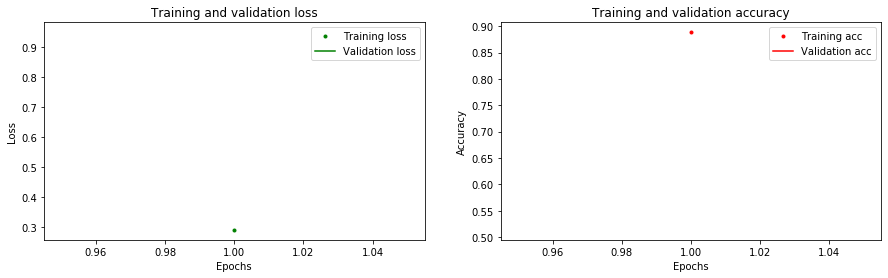

In [34]:
hist_cnn_2a = cnn_2a.history
loss_values = hist_cnn_2a['loss']
val_loss_values = hist_cnn_2a['val_loss']
acc_values = hist_cnn_2a['acc']
val_acc_values = hist_cnn_2a['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
cnn_2.save("cnn_2.h5")
print("Saved model to disk")

Saved model to disk


## Fine-Tuning

In [39]:
cnn_base.trainable = True

In [51]:
# Unfreeze cnn_base.
cnn_base.trainable = True 

# Refreeze all layers except for the last block of layers.
for layer in cnn_base.layers:
    if 'block8' in layer.name:
        layer.trainable = True
    elif 'conv_7b' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [52]:
#Double check that we unfroze only the last block of layers for the base_cnn.
for layer in cnn_base.layers:
    print(layer.name, layer.trainable)

input_1 False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
conv2d_3 False
batch_normalization_3 False
activation_3 False
max_pooling2d_1 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
conv2d_5 False
batch_normalization_5 False
activation_5 False
max_pooling2d_2 False
conv2d_9 False
batch_normalization_9 False
activation_9 False
conv2d_7 False
conv2d_10 False
batch_normalization_7 False
batch_normalization_10 False
activation_7 False
activation_10 False
average_pooling2d_1 False
conv2d_6 False
conv2d_8 False
conv2d_11 False
conv2d_12 False
batch_normalization_6 False
batch_normalization_8 False
batch_normalization_11 False
batch_normalization_12 False
activation_6 False
activation_8 False
activation_11 False
activation_12 False
mixed_5b False
conv2d_16 False
batch_normalization_16 False
activation_16 False
conv2d_14 False
conv2d_17 False
batch_normalization_14 False
batch_normalization_17

In [53]:
cnn_2.compile(loss='binary_crossentropy',
            optimizer="sgd",
            metrics=['acc'])

In [54]:
cnn_2b = cnn_2.fit(images_train,
               labels_train,
               epochs=1,
               batch_size=500,
               validation_data=(images_validation, labels_validation),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 30000 samples, validate on 5000 samples
Epoch 1/1
30000/30000 [==============================] - 3257s 109ms/step - loss: 0.0482 - acc: 0.9856 - val_loss: 0.3342 - val_acc: 0.8072


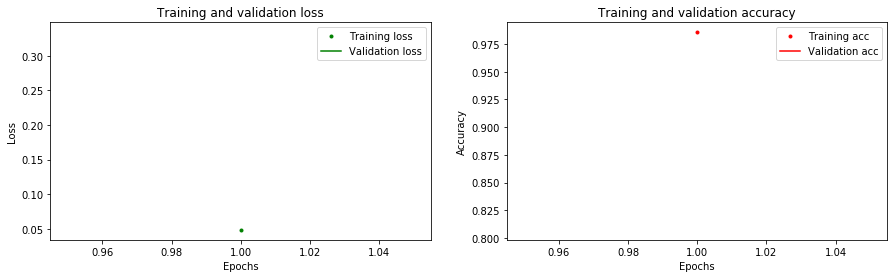

In [57]:
hist_cnn_2b = cnn_2b.history
loss_values = hist_cnn_2b['loss']
val_loss_values = hist_cnn_2b['val_loss']
acc_values = hist_cnn_2b['acc']
val_acc_values = hist_cnn_2b['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
cnn_2.save("cnn_2_tuned.h5")
print("Saved model to disk")

Saved model to disk


## Try More Epochs With Fine-Tuned Model

In [58]:
cnn_2c = cnn_2.fit(images_train,
               labels_train,
               epochs=10,
               batch_size=500,
               validation_data=(images_validation, labels_validation),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 2992s 100ms/step - loss: 0.0277 - acc: 0.9913 - val_loss: 0.1504 - val_acc: 0.9606
Epoch 2/10
30000/30000 [==============================] - 2995s 100ms/step - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0847 - val_acc: 0.9742
Epoch 3/10
30000/30000 [==============================] - 2999s 100ms/step - loss: 0.0155 - acc: 0.9954 - val_loss: 0.0461 - val_acc: 0.9868
Epoch 4/10
30000/30000 [==============================] - 2989s 100ms/step - loss: 0.0117 - acc: 0.9969 - val_loss: 0.0338 - val_acc: 0.9888
Epoch 5/10
30000/30000 [==============================] - 2998s 100ms/step - loss: 0.0103 - acc: 0.9973 - val_loss: 0.0233 - val_acc: 0.9934
Epoch 6/10
30000/30000 [==============================] - 2987s 100ms/step - loss: 0.0088 - acc: 0.9976 - val_loss: 0.0195 - val_acc: 0.9948
Epoch 7/10
30000/30000 [==============================] - 3001s 100ms/step - loss: 0.0071 - acc: 0.9983 -

In [170]:
hist_cnn_2c = cnn_2c.history
loss_values = hist_cnn_2c['loss']
val_loss_values = hist_cnn_2c['val_loss']
acc_values = hist_cnn_2c['acc']
val_acc_values = hist_cnn_2c['val_acc']
epochs = range(1, len(loss_values) + 1)

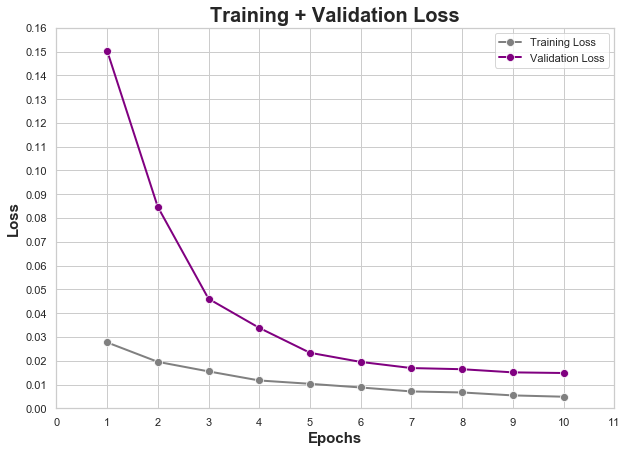

In [169]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.01))
sns.lineplot(epochs, loss_values, label='Training Loss', linewidth=2, marker='o', markersize=8, color='grey')
sns.lineplot(epochs, val_loss_values, label='Validation Loss', linewidth=2, marker='o', markersize=8, color='purple')
plt.title('Training + Validation Loss', size=20, weight='bold')
plt.xlabel('Epochs', size=15, weight='bold')
plt.ylabel('Loss', size=15, weight='bold')
plt.axis([0,11,0,.16])
plt.legend()
plt.show()
# plt.savefig('cnn_InceptionResNetV2_tuned_loss.pdf')

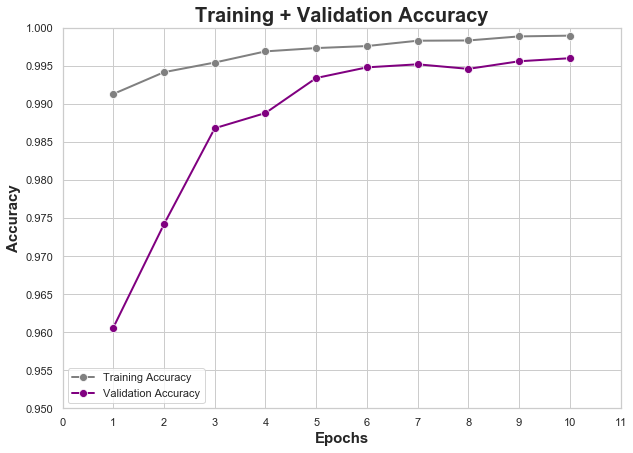

In [168]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.005))
sns.lineplot(epochs, acc_values, label='Training Accuracy', linewidth=2, marker='o', markersize=8, color='grey')
sns.lineplot(epochs, val_acc_values, label='Validation Accuracy', linewidth=2, marker='o', markersize=8, color='purple')
plt.title('Training + Validation Accuracy', size=20, weight='bold')
plt.xlabel('Epochs', size=15, weight='bold')
plt.ylabel('Accuracy', size=15, weight='bold')
plt.axis([0,11,.95,1])
plt.legend()
plt.show()
# plt.savefig('cnn_InceptionResNetV2_tuned_accuracy.pdf')

## Test Model

In [60]:
cnn_2.save("cnn_2_tuned.h5")
print("Saved model to disk")

Saved model to disk


In [7]:
cnn_loaded = load_model('cnn_2_tuned.h5')

In [11]:
images_test, labels_test = next(data_test)

In [12]:
cnn_loaded.evaluate(images_test, labels_test)

5000/5000 [==============================] - 360s 72ms/step


[0.017047405107133092, 0.9937999844551086]

In [13]:
y_pred = cnn_loaded.predict(images_test)

In [14]:
conf_matrix = pd.DataFrame(
    confusion_matrix(
        np.argmax(labels_test, axis=1),
        np.argmax(y_pred, axis=1)
    ),
    index = ['Actual Cracked', 'Actual Not Cracked'], 
    columns = ['Predicted Cracked', 'Predicted Not Cracked']
)
conf_matrix

,Predicted Cracked,Predicted Not Cracked
Actual Cracked,2479,21
Actual Not Cracked,10,2490


In [15]:
#recall
2479/(2479+21)

0.9916

In [16]:
#precision
2479/(2479+10)

0.9959823222177582

In [17]:
#accuracy
(2479+2490)/(2479+2490+10+21)

0.9938

In [18]:
#true negative rate
2490/(2490+10)

0.996